In [41]:
import os
import json
from glob import glob
import pandas as pd
import numpy as np
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [16]:
data = pd.read_csv("Duolingo Data/duolingo_es_en_train_data_clean.csv")
data

,block_id,token_id,token,pos,features,dep_rel,dep_parent,correctness,user_id,format,prompt,countries,days,client,session,time
0,block_1,d44lo//L0101,El,DET,Definite=Def|Gender=Masc|Number=Sing|PronType=...,det,2,0,+H9QWAV4,listen,NaN,CA,0.009,ios,lesson,9.0
1,block_1,d44lo//L0102,pan,NOUN,Gender=Masc|Number=Sing|fPOS=NOUN++,ROOT,0,0,+H9QWAV4,listen,NaN,CA,0.009,ios,lesson,9.0
2,block_2,d44lo//L0201,El,DET,Definite=Def|Gender=Masc|Number=Sing|PronType=...,det,2,0,+H9QWAV4,listen,NaN,CA,0.009,ios,lesson,8.0
3,block_2,d44lo//L0202,agua,NOUN,Gender=Fem|Number=Sing|fPOS=NOUN++,ROOT,0,0,+H9QWAV4,listen,NaN,CA,0.009,ios,lesson,8.0
4,block_3,d44lo//L0301,El,DET,Definite=Def|Gender=Masc|Number=Sing|PronType=...,det,2,0,+H9QWAV4,reverse_translate,The bread,CA,0.009,ios,lesson,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1973551,block_731894,3s8rjpVr0702,quién,PRON,"Number=Sing|PronType=Int,Rel|fPOS=PRON++",ROOT,0,0,yN35NfnY,reverse_tap,NaN,MX|US,12.253,android,lesson,3.0
1973552,block_731895,9Bx6fqpv0101,Según,ADP,fPOS=ADP++,case,2,0,yN35NfnY,listen,NaN,MX|US,12.835,android,lesson,7.0
1973553,block_731895,9Bx6fqpv0102,él,PRON,"Case=Acc,Nom|Gender=Masc|Number=Sing|Person=3|...",ROOT,0,0,yN35NfnY,listen,NaN,MX|US,12.835,android,lesson,7.0
1973554,block_731896,9Bx6fqpv0201,Según,ADP,fPOS=ADP++,case,2,0,yN35NfnY,reverse_tap,NaN,MX|US,12.835,android,lesson,5.0


In [ ]:
plot(data["days"]

# Feature Engineering

## Time-Based Features

In [17]:
# Churn Time - time difference between user's last and first activity
data['churn_time'] = data.groupby('user_id')['days'].transform(lambda x: x.max() - x.min())
data['churn_time'] = data['churn_time'].apply(np.floor)

# Time difference between consecutive activities
def assign_session(group):
    # Sort the group by 'days'
    group = group.sort_values("days").copy()
    # Calculate the time difference between consecutive rows
    group['time_diff'] = group['days'].diff().fillna(0)
    # A new session starts if the difference exceeds 0.0417 (approx. 1 hour)
    group['session_id'] = (group['time_diff'] > 0.0417).cumsum() + 1
    return group

data = data.groupby(['user_id'], group_keys=False).apply(assign_session)

# Churn time category (binned version of churn_time)
data['churn_time_category'] = pd.cut(data['churn_time'], 
                                    bins=[0, 7, 15, 1000], 
                                    labels=[1, 2, 3],
                                    include_lowest=True)

/var/folders/rk/chdw58s567j63rrc5xnh83gw0000gn/T/ipykernel_23084/1108031658.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby(['user_id'], group_keys=False).apply(assign_session)


## Correctness Features

In [18]:
# Block average correctness
data['block_average_correctness'] = data.groupby(['user_id', 'block_id'])['correctness'].transform('mean')

# Student average correctness (across all blocks)
student_data = data.groupby(['user_id', 'block_id'])['block_average_correctness'].mean().reset_index()
student_data = student_data.groupby(['user_id'])['block_average_correctness'].mean().reset_index()
## student_data.rename(columns={"block_average_correctness": "student_average_correctness"}, inplace=True)

# Token correctness - average correctness for each token
# data['token_correctness'] = data.groupby('token')['correctness'].transform('mean')

# Format-specific correctness
# Reverse tap average correctness
reverse_tap_correctness = data[data['format'] == 'reverse_tap'].groupby('user_id')['correctness'].mean().reset_index()
reverse_tap_correctness = reverse_tap_correctness.rename(columns={'correctness': 'reverse_tap_average_correctness'})

# Reverse translate average correctness
reverse_translate_correctness = data[data['format'] == 'reverse_translate'].groupby('user_id')['correctness'].mean().reset_index()
reverse_translate_correctness = reverse_translate_correctness.rename(columns={'correctness': 'reverse_translate_average_correctness'})

# Listen average correctness
listen_correctness = data[data['format'] == 'listen'].groupby('user_id')['correctness'].mean().reset_index()
listen_correctness = listen_correctness.rename(columns={'correctness': 'listen_average_correctness'})

## Response Time Features

In [19]:
# Response time variance
variance_df = data.groupby(['user_id', 'block_id'])['time'].mean().reset_index()
variance_df = variance_df.groupby('user_id')['time'].var().reset_index()
variance_df = variance_df.rename(columns={'time': 'response_time_variance'})
data = pd.merge(data, variance_df, on='user_id', how='left')

# Block average response time
block_avg_response_time = data.groupby(['user_id', 'block_id'])['time'].mean().reset_index()
block_avg_response_time_per_user = block_avg_response_time.groupby('user_id')['time'].mean().reset_index()
block_avg_response_time_per_user = block_avg_response_time_per_user.rename(columns={'time': 'block_average_response_time'})

# Format-specific average response times
# Reverse tap average response time
reverse_tap_response_time = data[data['format'] == 'reverse_tap'].groupby('user_id')['time'].mean().reset_index()
reverse_tap_response_time = reverse_tap_response_time.rename(columns={'time': 'reverse_tap_average_response_time'})

# Reverse translate average response time
reverse_translate_response_time = data[data['format'] == 'reverse_translate'].groupby('user_id')['time'].mean().reset_index()
reverse_translate_response_time = reverse_translate_response_time.rename(columns={'time': 'reverse_translate_average_response_time'})

# Listen average response time
listen_response_time = data[data['format'] == 'listen'].groupby('user_id')['time'].mean().reset_index()
listen_response_time = listen_response_time.rename(columns={'time': 'listen_average_response_time'})

## Token Easiness

In [86]:
# Block-wise token easiness - average token correctness for each block
# data["block_wise_token_easiness"] = data.groupby(['block_id'])['token_correctness'].transform('mean')

## Format Counts and Session Features

In [ ]:
# Session count - number of unique sessions per user
# student_session_data = data.groupby('user_id')['session_id'].nunique().reset_index(name='session_count')

# Block count - number of unique blocks per user
# student_block_data = data.groupby('user_id')['block_id'].nunique().reset_index(name='block_count')

# Format counts - number of times each format appears for each user
# format_data = data.groupby(['user_id', 'block_id'], as_index=False)['format'].first().reset_index()
# format_by_stud = pd.crosstab(format_data['user_id'], format_data['format']).reset_index()

## Ability Features

In [20]:
# Create an ability measure that combines correctness and response time
# Higher correctness and lower response times indicate higher ability
user_avg_correctness = data.groupby('user_id')['correctness'].mean().reset_index()
user_avg_response_time = data.groupby('user_id')['time'].mean().reset_index()

# Normalize response time (lower is better, so we invert it)
max_time = user_avg_response_time['time'].max()
user_avg_response_time['normalized_time'] = 1 - (user_avg_response_time['time'] / max_time)

# Create ability score (simple average of correctness and normalized time)
ability_score = pd.merge(user_avg_correctness, user_avg_response_time, on='user_id')
ability_score['user_ability_score'] = (ability_score['correctness'] + ability_score['normalized_time']) / 2

# Keep only user_id and ability score
ability_score = ability_score[['user_id', 'user_ability_score']]

## Count Features

In [21]:
# Create a discrete day variable from the floating-point 'days' column
data['day'] = data['days'].apply(np.floor)

# Now let's recalculate the count features using the new 'day' variable

# Blocks per session remains the same as it doesn't depend on days
blocks_per_session = data.groupby(['user_id', 'session_id'])['block_id'].nunique().reset_index()
blocks_per_session = blocks_per_session.rename(columns={'block_id': 'blocks_in_session'})

# Average number of blocks per session
avg_blocks_per_session = blocks_per_session.groupby('user_id')['blocks_in_session'].mean().reset_index()
avg_blocks_per_session = avg_blocks_per_session.rename(columns={'blocks_in_session': 'average_blocks_per_session'})

# Now use the discrete 'day' variable for daily counts
# Blocks per day: count unique blocks per user per day
user_days = data.groupby(['user_id', 'day'])['block_id'].nunique().reset_index()
user_days = user_days.rename(columns={'block_id': 'blocks_in_day'})

# Average number of blocks per day for each user
avg_blocks_per_day = user_days.groupby('user_id')['blocks_in_day'].mean().reset_index()
avg_blocks_per_day = avg_blocks_per_day.rename(columns={'blocks_in_day': 'average_blocks_per_day'})

# Sessions per day: count unique sessions per user per day
sessions_per_day = data.groupby(['user_id', 'day'])['session_id'].nunique().reset_index()
sessions_per_day = sessions_per_day.rename(columns={'session_id': 'sessions_in_day'})

# Average number of sessions per day for each user
avg_sessions_per_day = sessions_per_day.groupby('user_id')['sessions_in_day'].mean().reset_index()
avg_sessions_per_day = avg_sessions_per_day.rename(columns={'sessions_in_day': 'average_sessions_per_day'})

## Consistency Measures

In [22]:
# Session length variance
session_lengths = data.groupby(['user_id', 'session_id']).size().reset_index(name='session_length')
session_length_variance = session_lengths.groupby('user_id')['session_length'].var().reset_index()
session_length_variance = session_length_variance.rename(columns={'session_length': 'session_length_variance'})

# Variance of number of blocks per session
blocks_per_session_var = blocks_per_session.groupby('user_id')['blocks_in_session'].var().reset_index()
blocks_per_session_var = blocks_per_session_var.rename(columns={'blocks_in_session': 'blocks_per_session_variance'})

# Variance of number of blocks per day
blocks_per_day_var = user_days.groupby('user_id')['blocks_in_day'].var().reset_index()
blocks_per_day_var = blocks_per_day_var.rename(columns={'blocks_in_day': 'blocks_per_day_variance'})

# Variance of number of sessions per day
sessions_per_day_var = sessions_per_day.groupby('user_id')['sessions_in_day'].var().reset_index()
sessions_per_day_var = sessions_per_day_var.rename(columns={'sessions_in_day': 'sessions_per_day_variance'})

# Final User-Level Dataset

In [23]:
# Merge all the user-level features
user_features = pd.merge(student_data, reverse_tap_correctness, on='user_id', how='left')
user_features = pd.merge(user_features, reverse_translate_correctness, on='user_id', how='left')
user_features = pd.merge(user_features, listen_correctness, on='user_id', how='left')
user_features = pd.merge(user_features, block_avg_response_time_per_user, on='user_id', how='left')
user_features = pd.merge(user_features, reverse_tap_response_time, on='user_id', how='left')
user_features = pd.merge(user_features, reverse_translate_response_time, on='user_id', how='left')
user_features = pd.merge(user_features, listen_response_time, on='user_id', how='left')
user_features = pd.merge(user_features, ability_score, on='user_id', how='left')
user_features = pd.merge(user_features, avg_blocks_per_session, on='user_id', how='left')
user_features = pd.merge(user_features, avg_blocks_per_day, on='user_id', how='left')
user_features = pd.merge(user_features, avg_sessions_per_day, on='user_id', how='left')
user_features = pd.merge(user_features, session_length_variance, on='user_id', how='left')
user_features = pd.merge(user_features, blocks_per_session_var, on='user_id', how='left')
user_features = pd.merge(user_features, blocks_per_day_var, on='user_id', how='left')
user_features = pd.merge(user_features, sessions_per_day_var, on='user_id', how='left')
user_features = pd.merge(user_features, variance_df, on='user_id', how='left')

# Add churn time related features
churn_data = data.groupby("user_id")[["churn_time", "churn_time_category"]].first().reset_index()
user_features = pd.merge(user_features, churn_data, on='user_id', how='left')

# Impute missing data: Replace NaNs in format-specific metrics with 0
format_specific_columns = [
    'reverse_tap_average_correctness', 'reverse_translate_average_correctness', 'listen_average_correctness',
    'reverse_tap_average_response_time', 'reverse_translate_average_response_time', 'listen_average_response_time'
]
user_features[format_specific_columns] = user_features[format_specific_columns].fillna(0)

# Impute missing data: Replace NaNs in variance metrics with 0
variance_columns = ['blocks_per_day_variance', 'sessions_per_day_variance']
user_features[variance_columns] = user_features[variance_columns].fillna(0)

In [24]:
# Save the final raw dataset
user_features.to_csv("Duolingo_es_en_data_03_11_final_raw.csv", index=False) # 3 categories

In [25]:
df_raw = pd.read_csv("Duolingo_es_en_data_03_11_final_raw.csv")
pd.set_option('display.max_columns', None)
df_raw

,user_id,block_average_correctness,reverse_tap_average_correctness,reverse_translate_average_correctness,listen_average_correctness,block_average_response_time,reverse_tap_average_response_time,reverse_translate_average_response_time,listen_average_response_time,user_ability_score,average_blocks_per_session,average_blocks_per_day,average_sessions_per_day,session_length_variance,blocks_per_session_variance,blocks_per_day_variance,sessions_per_day_variance,response_time_variance,churn_time,churn_time_category
0,++wRkBMl,0.118939,0.041841,0.251185,0.115789,17.825175,9.355649,38.772512,17.396491,0.558999,15.888889,47.666667,3.000000,908.500000,149.751634,2679.066667,4.000000,471.913189,6.0,1
1,+1eKjQkd,0.149770,0.000000,0.153639,1.000000,26.016129,0.000000,33.204852,5.000000,0.569123,10.333333,13.777778,1.666667,386.992424,44.242424,17.944444,0.500000,35580.406242,15.0,2
2,+24bHaLs,0.085434,0.015625,0.107143,0.160584,12.857143,7.804688,13.071429,23.985401,0.541289,19.833333,23.800000,1.200000,1249.766667,240.166667,242.200000,0.200000,1532.835351,6.0,1
3,+8iRW0d/,0.055965,0.044621,0.186207,0.049333,12.183917,12.153198,17.924138,13.587928,0.524438,52.333333,54.608696,1.043478,17333.557971,1106.231884,1042.612648,0.043478,624.280889,24.0,3
4,+EIy/px1,0.085504,0.006711,0.143836,0.111538,40.925581,5.845638,18.479452,67.111538,0.534528,8.958333,23.888889,2.666667,243.244565,40.737319,160.611111,2.250000,148401.938361,7.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2638,zvEbGS/0,0.138797,0.076000,0.363057,0.100490,5.965517,4.892000,8.108280,7.355392,0.569746,17.722222,22.785714,1.285714,961.388889,165.624183,262.181319,0.219780,13.819562,16.0,3
2639,zvrrKF1A,0.201313,0.073684,0.167315,0.253682,53.485014,7.505618,17.012000,115.590219,0.578297,13.379310,25.866667,1.933333,676.044335,82.743842,118.266667,1.209524,622138.785977,14.0,2
2640,zw9uRP+u,0.037500,0.064516,0.084746,0.000000,17.400000,11.096774,20.915254,20.829787,0.513228,8.888889,8.888889,1.111111,135.277778,33.111111,40.611111,0.111111,1029.331646,10.0,2
2641,zzP0jnrU,0.080688,0.000000,0.132653,0.051724,11.101562,4.736842,14.291339,12.472973,0.535638,13.500000,21.000000,1.555556,1085.346154,138.884615,211.750000,0.527778,64.013226,7.0,1


In [26]:
# Check outliers in response_time_variance using IQR method
Q1 = df_raw['response_time_variance'].quantile(0.25)
Q3 = df_raw['response_time_variance'].quantile(0.75)
IQR = Q3 - Q1

# Count outliers (beyond 1.5 * IQR)
outliers = df_raw[(df_raw['response_time_variance'] < (Q1 - 1.5 * IQR)) | 
                  (df_raw['response_time_variance'] > (Q3 + 1.5 * IQR))]

print(f"Total outliers: {len(outliers)} out of {len(df_raw)} ({len(outliers)/len(df_raw)*100:.2f}%)")
print(f"Outlier threshold: > {Q3 + 1.5*IQR:.2f}")
print("\nTop 5 outliers:")
print(df_raw['response_time_variance'].nlargest(5))

Total outliers: 554 out of 2643 (20.96%)
Outlier threshold: > 6301.54

Top 5 outliers:
684     1.242694e+08
796     1.087720e+08
2078    1.053473e+08
353     9.776428e+07
1878    7.276620e+07
Name: response_time_variance, dtype: float64


In [27]:
# Standardize all numerical input features
# Categories of features to standardize:

# Define feature groups
variance_features = [
    'session_length_variance', 'blocks_per_session_variance',
    'blocks_per_day_variance', 'sessions_per_day_variance', 'response_time_variance'
]

time_features = [
    'block_average_response_time', 'reverse_tap_average_response_time',
    'reverse_translate_average_response_time', 'listen_average_response_time'
]

count_features = [
    'average_blocks_per_session', 'average_blocks_per_day', 'average_sessions_per_day'
]

# user ability score and correctness features are already standardized when engineered

# 1. Handle regular variance features with log transform
for feature in variance_features:
    user_features[feature] = np.log1p(user_features[feature])

# 2. Handle response_time_variance with QuantileTransformer, given 20% of the data are considered outliers above IQR
qt = QuantileTransformer(output_distribution='uniform')  # uniform keeps it in 0-1 range
user_features['response_time_variance'] = qt.fit_transform(
    user_features[['response_time_variance']])

# 3. Apply MinMaxScaler to all numerical features
all_standardized_features = variance_features + time_features + count_features + ['response_time_variance']

# Print which columns will be standardized for verification
print(f"Columns being standardized ({len(all_standardized_features)}):")
print(all_standardized_features)

min_max_scaler = MinMaxScaler()
user_features[all_standardized_features] = min_max_scaler.fit_transform(user_features[all_standardized_features])


# Print summary statistics to verify standardization worked
print("\nAfter standardization:")
print(user_features[all_standardized_features].describe())

Columns being standardized (13):
['session_length_variance', 'blocks_per_session_variance', 'blocks_per_day_variance', 'sessions_per_day_variance', 'response_time_variance', 'block_average_response_time', 'reverse_tap_average_response_time', 'reverse_translate_average_response_time', 'listen_average_response_time', 'average_blocks_per_session', 'average_blocks_per_day', 'average_sessions_per_day', 'response_time_variance']

After standardization:
       session_length_variance  blocks_per_session_variance  \
count              2633.000000                  2633.000000   
mean                  0.438336                     0.479174   
std                   0.118129                     0.120832   
min                   0.000000                     0.000000   
25%                   0.358408                     0.393398   
50%                   0.426846                     0.466726   
75%                   0.512339                     0.556468   
max                   1.000000               

In [28]:
# Save the final standardized datasaet
user_features.to_csv("Duolingo_es_en_data_03_11_final_standardized.csv", index=False)

In [32]:
df_fr = pd.read_csv("Duolingo_data_03_07_final_standardized.csv")
df_es_en = pd.read_csv("Duolingo_es_en_data_03_11_final_standardized.csv")
df_en_es = pd.read_csv("Duolingo_en_es_data_03_11_final_standardized.csv")
pd.set_option('display.max_columns', None)
df_total = pd.concat([df_fr,df_es_en,df_en_es])
df_total

,user_id,block_average_correctness,reverse_tap_average_correctness,reverse_translate_average_correctness,listen_average_correctness,block_average_response_time,reverse_tap_average_response_time,reverse_translate_average_response_time,listen_average_response_time,user_ability_score,average_blocks_per_session,average_blocks_per_day,average_sessions_per_day,session_length_variance,blocks_per_session_variance,blocks_per_day_variance,sessions_per_day_variance,response_time_variance,churn_time,churn_time_category
0,+4kwmfjD,0.227673,0.133858,0.378947,0.375000,0.002246,0.031466,0.003641,0.008832,0.610942,0.508028,0.514156,0.444444,0.755147,0.789055,0.000000,0.000000,0.163987,0.0,1
1,+IUzKF2l,0.332900,0.212815,0.500000,0.607595,0.002769,0.033279,0.003321,0.011009,0.646135,0.177752,0.045300,0.000000,0.329076,0.356443,0.441670,0.000000,0.237942,22.0,3
2,+Xv/6Nop,0.229710,0.140162,0.375000,0.397849,0.005831,0.044804,0.004645,0.015200,0.606883,0.300131,0.130238,0.133333,0.539885,0.622328,0.744112,0.225838,0.784566,5.0,1
3,+mMyHsNU,0.239135,0.000000,0.250307,0.225892,0.004481,0.000000,0.001964,0.008600,0.613978,0.322248,0.283126,0.355556,0.775884,0.715246,0.800309,0.458726,0.536977,6.0,1
4,+ziSnwWC,0.169845,0.065789,0.266409,0.328947,0.005608,0.024309,0.006240,0.010858,0.590596,0.069626,0.036523,0.166667,0.320580,0.380484,0.539567,0.252993,0.495177,13.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2588,zv3rQx2W,0.146138,0.000000,0.181818,0.119914,0.006873,0.000000,0.001910,0.007430,0.567940,0.019772,0.043754,0.157143,0.368187,0.288287,0.545046,0.233517,0.218360,10.0,2
2589,zx+JF92P,0.104308,0.028689,0.112281,0.174797,0.002095,0.003862,0.001154,0.005327,0.549634,0.037566,0.115723,0.257143,0.470998,0.425516,0.706317,0.591103,0.380547,4.0,1
2590,zyRFO2/B,0.156784,0.040900,0.228802,0.195122,0.022996,0.002765,0.006811,0.006986,0.566220,0.200404,0.192232,0.040816,0.825880,0.823365,0.815875,0.072535,0.887942,9.0,2
2591,zzZcZM/K,0.128826,0.028409,0.160920,0.292453,0.016392,0.016277,0.003000,0.026308,0.554183,0.002965,0.014830,0.226190,0.076620,0.078015,0.391949,0.437740,0.832677,15.0,2


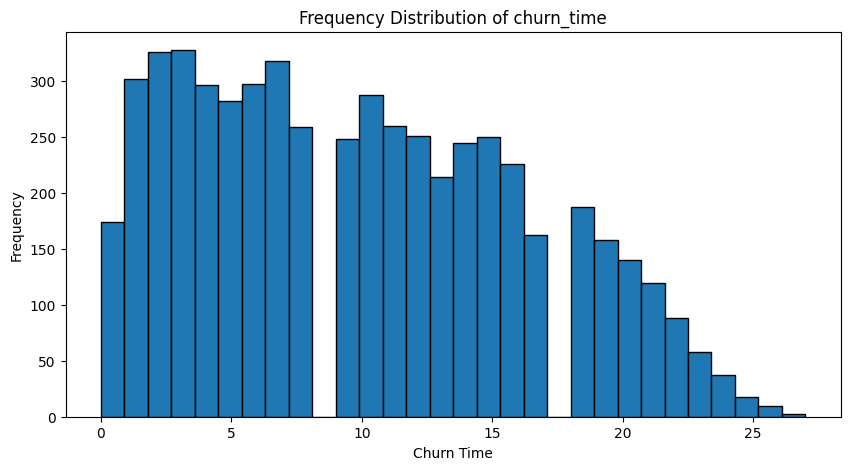

In [43]:
plt.figure(figsize=(10, 5))
plt.hist(df_total['churn_time'], bins=30, edgecolor='black')
plt.title('Frequency Distribution of churn_time')
plt.xlabel('Churn Time')
plt.ylabel('Frequency')
plt.show()

In [45]:
bins = [0, 7, 14, 21, 28]
labels = ['0-7', '7-14', '14-21', '21-28']

# Bin the churn_time values. Using right=False makes the intervals [0,7), [7,14), etc.
df_total['churn_category_test'] = pd.cut(df_total['churn_time'], bins=bins, labels=labels, right=False)

# Calculate the frequency of each churn_time category
frequency = df_total['churn_category_test'].value_counts().sort_index()

print(frequency)

churn_category_test
0-7      2007
7-14     1838
14-21    1370
21-28     333
Name: count, dtype: int64
